In [12]:
import os
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, PNDMScheduler
from PIL import Image
from torch import nn
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

# Setup
diffusion_model_id = 'runwayml/stable-diffusion-v1-5'
text_encoder_model_id = 'openai/clip-vit-large-patch14'
device = 'cuda'
seed = 1024
train_data_dir = 'data'

# Hugging Face access token
token = ''
with open('hugging_face_token.txt', 'r') as secret:
    token = secret.readline().strip()

In [ ]:
class XDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property='object',  # [object, style]
        size=512,
        repeats=100,
        interpolation='bicubic',
        flip_p=0.0,  # 0.5 default
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):
        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p
        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]
        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == 'train':
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL_INTERPOLATION["linear"],
            "bilinear": PIL_INTERPOLATION["bilinear"],
            "bicubic": PIL_INTERPOLATION["bicubic"],
            "lanczos": PIL_INTERPOLATION["lanczos"],
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        # Convert image to RGB if needed
        if not image.mode == 'RGB':
            image = image.convert('RGB')

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example


In [ ]:
# Load model components

# Text Encoder + Tokenizer
tokenizer = CLIPTokenizer.from_pretrained(text_encoder_model_id)
text_encoder = CLIPTextModel.from_pretrained(text_encoder_model_id, torch_dtype=torch.float16)
text_encoder.to(device)

# Variational Autoencoder
vae = AutoencoderKL.from_pretrained(
    diffusion_model_id, subfolder='vae', torch_dtype=torch.float16,
    revision='fp16', use_auth_token=token)
vae.to(device)

# U-Net Model
u_net = UNet2DConditionModel.from_pretrained(
    diffusion_model_id, subfolder='unet', torch_dtype=torch.float16,
    revision='fp16', use_auth_token=token)
u_net.to(device)

In [5]:
# Freeze parameters for a model
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze all pre-trained models
freeze_params(text_encoder.parameters())
freeze_params(vae.parameters())
freeze_params(u_net.parameters())

In [13]:
# Noise Scheduler

#scheduler = DDIMScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)
#scheduler = LMSDiscreteScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)
scheduler = PNDMScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)

In [6]:
# Encode input prompt
def encode_prompt(prompt):
    # Tokenize text and get embeddings
    text_inputs = tokenizer(
        prompt, padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    with torch.no_grad():
        text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]

    # Do the same for unconditional embeddings
    unconditional_input = tokenizer(
        [''], padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    unconditional_embeddings = text_encoder(unconditional_input.input_ids.to(device))[0]

    # Concatenate for final embeddings
    text_embeddings = torch.cat([unconditional_embeddings, text_embeddings])
    return text_embeddings

In [7]:
# Prepare latents for denoising
def prepare_latents(height=512, width=512, latents=None):
    if latents is None:
        shape = (1, u_net.in_channels, height // 8, width // 8)
        latents = torch.randn(shape, device=device, dtype=torch.float16)
    latents = latents.to(device)
    latents *= scheduler.init_noise_sigma
    return latents

In [48]:
# Decode latents into an image
def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image

In [52]:
class PromptEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.prompt_layer = nn.Sequential(
            nn.Linear(2 * 77 * 768, 10, dtype=torch.float16),
            nn.Linear(10, 2 * 77 * 768, dtype=torch.float16))

    def forward(self, inputs):
        encoded = encode_prompt(inputs)
        prompted = self.prompt_layer(torch.flatten(encoded))
        return prompted.unflatten(0, encoded.shape)

prompt_encoder = PromptEncoder().to(device)

In [14]:
def eval_model(prompt, num_inference_steps=50, guidance_scale=7.5):
    # Set random seed
    torch.manual_seed(seed)

    # Encode input prompt
    #prompt_embeddings = encode_prompt(prompt)
    prompt_embeddings = prompt_encoder(prompt)

    # Prepare timesteps
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = scheduler.timesteps

    # Prepare latent variables
    latents = prepare_latents()

    # Denoising Loop
    for i, t in enumerate(tqdm(timesteps)):
        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        with torch.no_grad():
            noise_pred = u_net(latent_model_input, t, encoder_hidden_states=prompt_embeddings).sample

        # Perform guidance
        noise_pred_unconditional, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_unconditional + guidance_scale * (noise_pred_text - noise_pred_unconditional)

        # Compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents
    decoded = decode_latents(latents)

    # Return image
    images = (decoded * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

  0%|          | 0/51 [00:00<?, ?it/s]

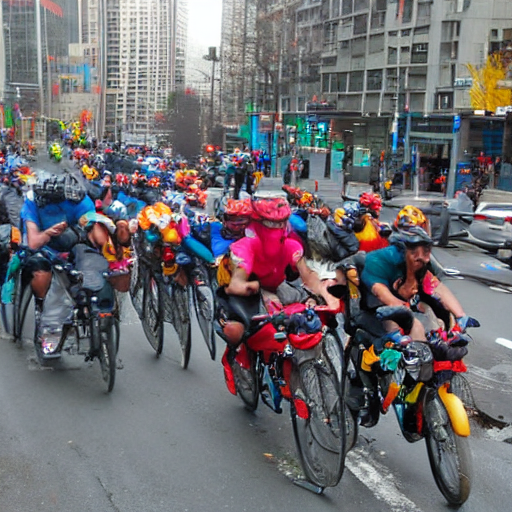

In [53]:
# Inference
prompt = 'people'
generated_img = eval_model(prompt, guidance_scale=10)
#generated_img.save('test.png')
generated_img